# Финальное задание
Перепешите код ниже на pyspark.  
Для оценки модели используйте [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html)

Ниже пару примеров для наглядности:

# Кредитный скоринг

При принятии решения о выдаче кредита или займа учитывается т.н. «Кредитный скоринг» — рейтинг платежеспособности клиента. На основе модели, которая основывается на возрасте, зарплате, кредитной истории, наличия недвижимости, автомобиля, судимости и других признаков, после обработки которых выносится положительное или отрицательное решение.

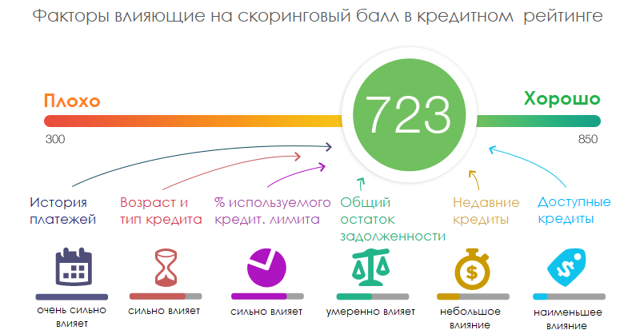

In [3]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 33.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=f181324204bf618a9809fc84d371269daa275777d148f42284b5f8079cb1dc35
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [4]:
# Импортируем библиотеки
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master('local[4]')\
        .appName('Lesson_4')\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.instances', 2)\
        .config('spark.executor.memory', '5g')\
        .config('spark.executor.cores', 2)\
        .getOrCreate()

sc = spark.sparkContext

In [6]:
spark

In [7]:
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

In [8]:

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# # Загружаем данные (проба записи данных по предыдущей лекции, чтобы проверить, подгрузились ли они)
data = sc.textFile('/content/application_record.csv')
record = sc.textFile('/content/credit_record.csv')

In [22]:
data.take(6)

['ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS',
 '5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,,2.0',
 '5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,,2.0',
 '5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0',
 '5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0',
 '5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0']

In [23]:
# данные spark
data = spark.read.csv('/content/application_record.csv')
record = spark.read.csv('/content/credit_record.csv')

In [25]:
data.show

<bound method DataFrame.show of DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string]>

In [44]:
data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)



In [ ]:
#################################################################################################

In [ ]:

# # Добавляем срок кредита к параметрам выдачи кредита
begin_month = sc.sparkContext.binaryRecords(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min) * - 1)
begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data = pd.merge(data, begin_month, how="left", on="ID") 

# # Больше 60, то это просрочка, ставим - Yes, если просрочка есть за срок кредита,то так же ставим Yes
record['dep_value'] = None
record['dep_value'][record['STATUS'] == '2'] = 'Yes'
record['dep_value'][record['STATUS'] == '3'] = 'Yes'
record['dep_value'][record['STATUS'] == '4'] = 'Yes'
record['dep_value'][record['STATUS'] == '5'] = 'Yes'
cpunt = record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0] = 'Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0] = 'No'

# # Джойним всё вместе,заменяем Yes и No на 1 и 0
cpunt = cpunt[['dep_value']]
new_data = pd.merge(new_data, cpunt, how='inner', on='ID')
new_data['target'] = new_data['dep_value']
new_data.loc[new_data['target'] == 'Yes','target'] = 1
new_data.loc[new_data['target'] == 'No','target'] = 0

In [ ]:
#  В итоге к анкетным данным мы добавили таргет
new_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14.0,No,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26.0,No,0


In [ ]:
# Упростим себе задачу и оставим только часть признаков
features = ['AMT_INCOME_TOTAL', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']	
target = ['target',]
dataset = new_data[features + target]
dataset[target[0]] = pd.to_numeric(dataset[target[0]])

In [ ]:
# Разделим выборку на трейн и тест, на трейн будем обучать модель, на тест валидировать.
X_train, X_test, y_train, y_test = train_test_split(dataset[features], pd.to_numeric(dataset[target[0]]), test_size=0.3, random_state=42)

In [ ]:
# Превращаем категориальные факторы в численные
ohe = OneHotEncoder()
ohe.fit(X_train[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']])
X_train_ohe = ohe.transform(X_train[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']])
X_test_ohe = ohe.transform(X_test[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']])

X_train_ohe = pd.DataFrame(X_train_ohe.toarray(), columns=[item for sublist in ohe.categories_ for item in sublist])
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=[item for sublist in ohe.categories_ for item in sublist])

In [ ]:
# Отскалируем численные
mms = MinMaxScaler()
mms.fit(X_train[['AMT_INCOME_TOTAL', 'CNT_CHILDREN']])
X_train_scaled = mms.transform(X_train[['AMT_INCOME_TOTAL', 'CNT_CHILDREN']])
X_test_scaled = mms.transform(X_test[['AMT_INCOME_TOTAL', 'CNT_CHILDREN']])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=['AMT_INCOME_TOTAL', 'CNT_CHILDREN'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['AMT_INCOME_TOTAL', 'CNT_CHILDREN'])

In [ ]:
X_train = pd.concat([X_train_scaled, X_train_ohe,], axis=1)
X_test = pd.concat([X_test_scaled, X_test_ohe, ], axis=1)

#  Модель

In [ ]:
# Создадим простейшую модель, которая покажет через линейные коэффиценты связь переменных и таргета
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
train_score, test_score = accuracy_score(model.predict(X_train), y_train), accuracy_score(model.predict(X_test), y_test)
print(f'Точность модели на трейне {train_score}, на тесте {test_score}')

Точность модели на трейне 0.9828755045260394, на тесте 0.983635033827025
